In [1]:
# limit for 2 tag
import ROOT as rt
import math
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os
from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from limit_plots import *

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()

print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
limitTrees =OrderedDict()
dataCards = OrderedDict()

limitTrees_obs =OrderedDict()
dataCards_obs = OrderedDict()
limitTrees_hybridNew = OrderedDict()

version = '/V1p17/v2/v163/'
dc_version = 'v9'

nrechit = 100

mode = 'allProd_withggZH'
decay = '4Tau'
decay = 'dddd'
decay = 'bbbb'

samples = [
'allProd_withggZH_HToSS_SToEE_ms0p4',
'allProd_withggZH_HToSS_SToGammaGamma_ms0p4',
'allProd_withggZH_HToSS_SToKPlusKMinus_ms1p5',
'allProd_withggZH_HToSS_SToK0K0_ms1p5',
'allProd_withggZH_HToSS_SToPi0Pi0_ms0p4',
'allProd_withggZH_HToSS_SToPi0Pi0_ms1p0',
'allProd_withggZH_HToSS_SToPiPlusPiMinus_ms0p4',
'allProd_withggZH_HToSS_SToPiPlusPiMinus_ms1p0',
'allProd_withggZH_HToSS_STodd_ms3p0',
'allProd_withggZH_HToSS_STodd_ms7',
'allProd_withggZH_HToSS_STodd_ms15',
'allProd_withggZH_HToSS_STodd_ms40',
'allProd_withggZH_HToSS_STodd_ms55',
'allProd_withggZH_HToSS_SToTauTau_ms7',
'allProd_withggZH_HToSS_SToTauTau_ms15',
'allProd_withggZH_HToSS_SToTauTau_ms40',
'allProd_withggZH_HToSS_SToTauTau_ms55',
'allProd_withggZH_HToSS_SToBB_ms15',
'allProd_withggZH_HToSS_SToBB_ms40',
'allProd_withggZH_HToSS_SToBB_ms55'
]


methodA = False
unblind = 'unblindABC'
hybridNew = 0
category = '/all_cat/'

# category = '/csc_twotag/'

limitDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees_2tag/'+version+'/'+dc_version+'/'
dataCardDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards_2tag/'+version+'/'+dc_version+'/'
hybridNewDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/hybridNew/'+version+'/'+dc_version+'/'


lumi = 137000
nCsc = 100
nDt = 80

ctaus = np.array([0.1, 0.125, 0.15, 0.175, 0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9, 1,1.25, 1.5, 1.75, 2,2.25,2.5,2.75,3,3.25,3.5,3.75, 4,5, 6,7,8,9,10, 11,12,13,14,15, 16,17,18,19,20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300,325, 350, 375, 400, 425, 450, 475, 500, \
                  600,700,800, 900, 1000, 1250, 1500, 1750, 2000,2250, 2500, 2750, \
                  3000, 3250, 3500, 3750, 4000, 5000, 6000, 7000, 8000, 9000,\
                  10000, 15000, 20000, 30000, 100000,int(2e5),int(3e5),\
                        int(2e6),int(3e6),int(5e6),int(1e7)]) #v12


if decay == 'bbbb': mass = np.array([ 15, 40, 55])
else:mass = np.array([ 7, 15, 40, 55])

### limit branch: 2.5, 16.0, 50.0, 84.0, 97.5, obs
expected = ['0.025', '0.160','0.500','0.840','0.975']


for m in samples:
    limitTrees[m] = {}
    dataCards[m] = {}
    limitTrees_hybridNew[m] = {}
    for ct in ctaus:
        name = mode+'_HToSSTo'+decay
        ct_str = str(ct).replace('.','p')
        if ct == int(ct):ct_str = str(int(ct)).replace('.','p')
        else: ct_str = str(ct).replace('.','p')
        dataCards[m][ct] = dataCardDir + '/'+unblind+category+m+'_ctau'+ct_str+'mm_nCsc'+ str(nCsc)+'_nDt'+str(nDt)+'.txt'
        limitTrees[m][ct] = limitDir + '/'+unblind+category+'/higgsCombine.'+m+'_ctau'+ct_str+'mm_nCsc'+ str(nCsc)+'_nDt'+str(nDt)+'.AsymptoticLimits.mH120.root'


norms = []
limits = {}
for i,m in enumerate(limitTrees.keys()):
    if unblind == 'blind' or unblind == 'unblindABC': limits[m] = np.ones((len(ctaus), 5))*1000000
    else:limits[m] = np.ones((len(ctaus), 6))*1000000
    for j, k in enumerate(limitTrees[m].keys()):
        line = open(dataCards[m][k], "r").readline()
        if not line.split(" ")[0] == '#' :continue
        signal_norm = float(line.split(" ")[3])
        
        if signal_norm == 0:continue
        if hybridNew:
            for n in range(6):
                if len(uproot.open(limitTrees[m][k][n]).keys()) == 2:
                    T = uproot.open(limitTrees[m][k][n])['limit']
                    if len(np.array(T.array('limit'))>0):limits[m][j][n] = np.array(T.array('limit'))/signal_norm
                
        else:
            if len(uproot.open(limitTrees[m][k]).keys()) == 2:
                T = uproot.open(limitTrees[m][k])['limit']                
                if len(np.array(T.array('limit'))>0):limits[m][j] = np.array(T.array('limit'))/signal_norm
    limits[m] = np.array(limits[m])

print(ctaus)



[1.00e-01 1.25e-01 1.50e-01 1.75e-01 2.00e-01 2.50e-01 3.00e-01 3.50e-01
 4.00e-01 5.00e-01 6.00e-01 7.00e-01 8.00e-01 9.00e-01 1.00e+00 1.25e+00
 1.50e+00 1.75e+00 2.00e+00 2.25e+00 2.50e+00 2.75e+00 3.00e+00 3.25e+00
 3.50e+00 3.75e+00 4.00e+00 5.00e+00 6.00e+00 7.00e+00 8.00e+00 9.00e+00
 1.00e+01 1.10e+01 1.20e+01 1.30e+01 1.40e+01 1.50e+01 1.60e+01 1.70e+01
 1.80e+01 1.90e+01 2.00e+01 2.50e+01 3.00e+01 3.50e+01 4.00e+01 4.50e+01
 5.00e+01 5.50e+01 6.00e+01 6.50e+01 7.00e+01 7.50e+01 8.00e+01 8.50e+01
 9.00e+01 9.50e+01 1.00e+02 1.25e+02 1.50e+02 1.75e+02 2.00e+02 2.25e+02
 2.50e+02 2.75e+02 3.00e+02 3.25e+02 3.50e+02 3.75e+02 4.00e+02 4.25e+02
 4.50e+02 4.75e+02 5.00e+02 6.00e+02 7.00e+02 8.00e+02 9.00e+02 1.00e+03
 1.25e+03 1.50e+03 1.75e+03 2.00e+03 2.25e+03 2.50e+03 2.75e+03 3.00e+03
 3.25e+03 3.50e+03 3.75e+03 4.00e+03 5.00e+03 6.00e+03 7.00e+03 8.00e+03
 9.00e+03 1.00e+04 1.50e+04 2.00e+04 3.00e+04 1.00e+05 2.00e+05 3.00e+05
 2.00e+06 3.00e+06 5.00e+06 1.00e+07]


# scale limit by BR

{'EE': [0.4], 'GammaGamma': [0.4], 'KPlusKMinus': [1.5], 'K0K0': [1.5], 'Pi0Pi0': [0.4, 1.0], 'PiPlusPiMinus': [0.4, 1.0], 'dd': [3.0, 7.0, 15.0, 40.0, 55.0], 'TauTau': [7.0, 15.0, 40.0, 55.0], 'BB': [15.0, 40.0, 55.0]}
{'EE': ['0p4'], 'GammaGamma': ['0p4'], 'KPlusKMinus': ['1p5'], 'K0K0': ['1p5'], 'Pi0Pi0': ['0p4', '1p0'], 'PiPlusPiMinus': ['0p4', '1p0'], 'dd': ['3p0', '7', '15', '40', '55'], 'TauTau': ['7', '15', '40', '55'], 'BB': ['15', '40', '55']}
6
3
2


TypeError: must be str, not list

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


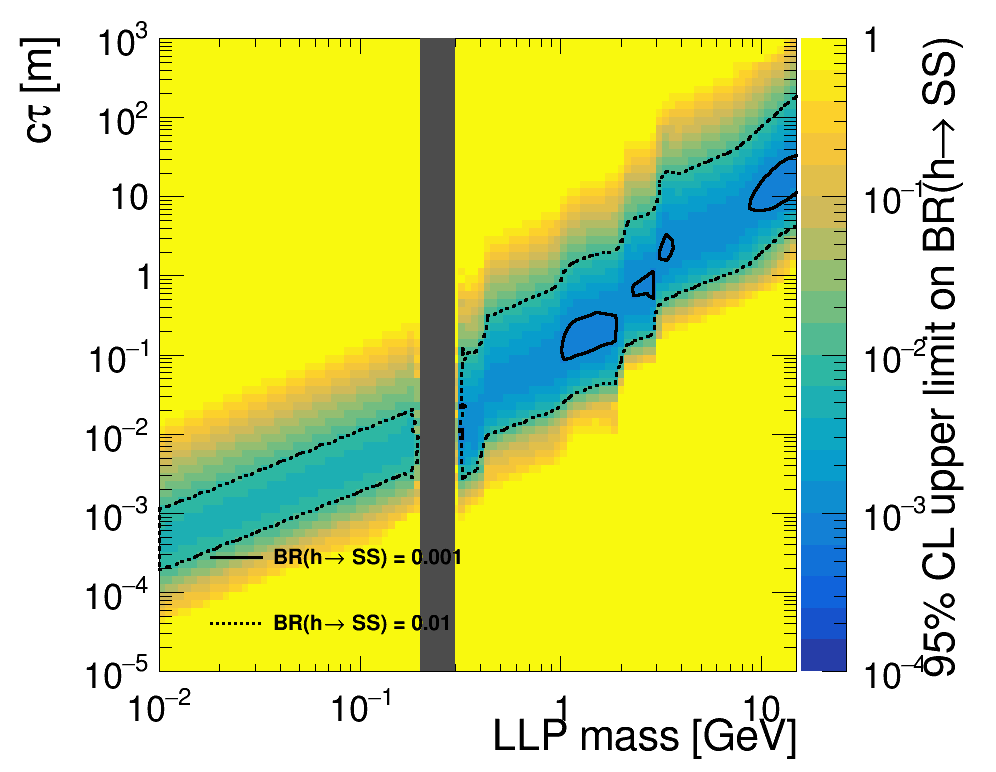

In [24]:
decays =['EE', 'GammaGamma', 'KPlusKMinus', 'K0K0', 'Pi0Pi0', 'PiPlusPiMinus', 'dd', 'TauTau', 'BB']
pid = [11, 22,321,311,111,211,1,15,5]
mass = {}
mass_string = {}
for d in decays:
    mass[d] = []
    mass_string[d] = []
    for s in samples:
        if d in s:
            mass[d].append(float(s[s.find('ms')+2:].replace('p','.')))
            mass_string[d].append(s[s.find('ms')+2:])
print(mass)
print(mass_string)
opac_1sig = 0.25
opac_2sig = 0.1

leg = rt.TLegend(0.2,0.15,0.5,0.32)

leg.SetFillStyle(0)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
rt.gStyle.SetLegendFillColor(1)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 1000, 800)
c.SetRightMargin(0.04)

rt.gStyle.SetOptFit(1011)
ctaus_m = ctaus/1000

sample_temp = []
m_sample = []
x = array('d',[])
y = array('d',[])
z = array('d',[])

max_mass = 15    
min_mass = 0.01

h = create_TH2D(np.column_stack((np.array(0), np.array(0))), axis_title = ['LLP mass [GeV]','c#tau [m]','95% CL upper limit on BR(h#rightarrow SS)'], \
                binning = [100,math.log10(min_mass),math.log10(max_mass),80,-5,3])

br_path = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/branchingRatio_phi/'

for filename in os.listdir(br_path): # loop over mass points from 0.1 to 40 GeV
    f = os.path.join(br_path, filename)
    if os.path.isfile(f) and '.txt' in filename and filename[:3] == 'phi':
        m = float(filename[4:-4].replace('dot', '.'))
        if m == 0:continue
        if m <= 0.2:continue # use just EE for below 0.2
            
        br = []
        decay = []
        total_limits = np.array([])
        with open(f) as fi:
            lines = fi.readlines()
            for i_line,line in enumerate(lines): #loop over all decay modes
                if not '9000006:addChannel' in line:continue
                br_line = line[line.find('=')+2:].split(" ")
                assert(abs(float(br_line[3])) == abs(float(br_line[4])))
                if abs(float(br_line[3])) == 13:continue
                if abs(float(br_line[3])) == 3 or abs(float(br_line[3])) == 4 or abs(float(br_line[3])) == 21:
                    decay.append(1)
                else:decay.append(abs(float(br_line[3])))
                br.append(float(br_line[1]))
                if decay[-1] not in pid:print('PARTICLE NOT FOUND', br_line[3])
        
                # find which sample and mass point to use
                use_m_s = 0.0
                list_of_m = mass[decays[pid.index(decay[-1])]]
                if m>np.max(list_of_m): 
                    use_m_s = np.max(list_of_m)
                    index = np.argmax(list_of_m)
                else:
                    for i, m_s in enumerate(list_of_m):
                        if m <= m_s:
                            use_m_s = m_s
                            index = i
                            break
                            
                # find sample corresponding to the mass and decay mode
                sample_name = 'allProd_withggZH_HToSS_STo'+decays[pid.index(decay[-1])]+'_ms'+mass_string[decays[pid.index(decay[-1])]][index]
                assert(sample_name in samples)
                if len(total_limits) == 0:
                    x += array('d', [math.log10(float(m))]*len(ctaus_m))
                    y += array('d', np.log10(ctaus_m/use_m_s*m))
                    total_limits = 1./limits[sample_name][:,2]*br[-1]
                else:
                    total_limits += 1./limits[sample_name][:,2]*br[-1]
                
            total_limits = np.log10(1./total_limits)

            for j in range(len(ctaus_m)):
                    h.SetBinContent(h.GetXaxis().FindBin(math.log10(float(m))), h.GetYaxis().FindBin(math.log10(ctaus_m[j]/use_m_s*m)),\
                                    10**(total_limits[j]))
            z += array('d', list(total_limits))
        
        
# add points for mass point below 0.2 GeV, use ee decay mode for this
for logm in np.arange(-2,math.log10(0.2),0.01):
    m = 10.0**float(logm)
    sample_name = 'allProd_withggZH_HToSS_SToEE_ms0p4' #always decay to EE
    cond = np.logical_and(limits[sample_name][:,2] < 20, np.logical_not(ctaus_m==0.001))            
    cond = np.logical_and(cond, ctaus_m > 0.002)
    x += array('d', [math.log10(float(m))]*len(ctaus_m[cond]))
    y += array('d', np.log10(ctaus_m[cond]/0.4*m))
    z += array('d', np.log10(limits[sample_name][:,2][cond]))
    for j in range(len(ctaus_m[cond])):
        h.SetBinContent(h.GetXaxis().FindBin(math.log10(float(m))), h.GetYaxis().FindBin(math.log10(ctaus_m[cond][j]/0.4*m)),limits[sample_name][:,2][cond][j])

# for mass point from 0.2-0.3GeV
for logm in np.arange(math.log10(0.2),math.log10(0.3),0.01):
    m = 10.0**float(logm)
    
    sample_name = 'allProd_withggZH_HToSS_SToEE_ms0p4' #always decay to EE
    cond = np.logical_and(limits[sample_name][:,2] < 20, np.logical_not(ctaus_m==0.001))       
    cond = np.logical_and(cond, ctaus_m > 0.002)
    x += array('d', [math.log10(float(m))]*len(ctaus_m[cond]))
    y += array('d', np.log10(ctaus_m[cond]/0.4*m))
    z += array('d', np.log10(limits[sample_name][:,2][cond]/0.001))
    for j in range(len(ctaus_m[cond])):
        h.SetBinContent(h.GetXaxis().FindBin(math.log10(float(m))), h.GetYaxis().FindBin(math.log10(ctaus_m[cond][j]/0.4*m)),1000*limits[sample_name][:,2][cond][j])

        


# h = interpolate2D(x,y,z, h, 0.1,0, inter = 'linear', norm = 'seuclidean')
# x = array('d', [])
# y = array('d', [])
# z = array('d', [])
# for i in range(1, h.GetNbinsX()+1):
#     for j in range(1, h.GetNbinsY()+1):
#         if not math.isnan(h.GetBinContent(i,j)) and not h.GetBinContent(i,j) == 0:
#             x.append(h.GetXaxis().GetBinCenter(i))
#             y.append(h.GetYaxis().GetBinCenter(j))
#             z.append(math.log10(h.GetBinContent(i,j)))


h = interpolate2D(x,y,z, h, 0.02,0.1, inter = 'rbf', norm = 'euclidean')

tdrstyle.setTDRStyle()




# #############
# plot contour
# #############

contours = array('d',[ 0.001, 0.01])
hframed = frameTH2D(h)
hframed = log_scale_conversion(hframed)
hframed.SetContour(len(contours),contours)
hframed.SetMaximum(1)
hframed.SetMinimum(0.0005)
hframed.Draw("CONT Z LIST")

rt.gPad.Update()

h = log_scale_conversion(h)
h.SetMinimum(1e-4)
h.SetMaximum(1) 
h.Draw('colz')

conts = rt.gROOT.GetListOfSpecials().FindObject("contours")
cont_gr = []
for i in range(conts.GetSize()):
    contour0 = conts.At(i)
    curv = contour0.First()
    finalcurv = rt.TGraph(1)
    print(contour0.GetSize())
    try:
        curv.SetLineWidth(3)
        curv.SetLineColor(std_color_list[0])
        if i == 0:curv.SetLineStyle(1)
        else: curv.SetLineStyle(2)
        curv.Draw("lsame")
        finalcurv = curv.Clone()
        maxN = curv.GetN()
    except AttributeError:
        print ("ERROR: no curve drawn for contour %s "%(i))
    for j in range(1, contour0.GetSize()):
        curv = contour0.After(curv)
        curv.SetLineWidth(3)
        curv.SetLineColor(std_color_list[0])
        if i == 0:curv.SetLineStyle(1)
        else: curv.SetLineStyle(2)
        curv.Draw("lsame")
        if curv.GetN()>maxN:
            maxN = curv.GetN()
            finalcurv = curv.Clone()
    cont_gr.append(finalcurv)
print(len(cont_gr))
for i in range(len(cont_gr)):
    leg.AddEntry(cont_gr[i],'BR(h#rightarrow SS) = '+str(contours[i]), 'L')

b = rt.TBox(0.2,1e-5,0.3, 1e3)
b.SetFillColor(12)
# b.SetFillColorAlpha(15,1)
b.Draw('fsame')   
        
leg.Draw()

c.SetRightMargin(0.2)

c.SetLogz()
c.SetLogx()
c.SetLogy()



c.Draw()

#### save plot

output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/limits/'+version+'/'+dc_version+'/'+unblind+'/'
if not os.path.isdir(output_dir):os.makedirs(output_dir)
name = output_dir+mode+'_HToSSTo'+decay


# #     print(name)
c.SaveAs(name+'_2d_expected.png')
c.SaveAs(name+'_2d_expected.C')
c.SaveAs(name+'_2d_expected.pdf')

#     tdrstyle.setTDRStyle()
#     c.Draw()


Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/limits//V1p17/v2/v163//v9/unblindABC/2dlimit_mixbr_2d_expected.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/limits//V1p17/v2/v163//v9/unblindABC/2dlimit_mixbr_2d_expected.C has been generated
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/limits//V1p17/v2/v163//v9/unblindABC/2dlimit_mixbr_2d_expected.pdf has been created


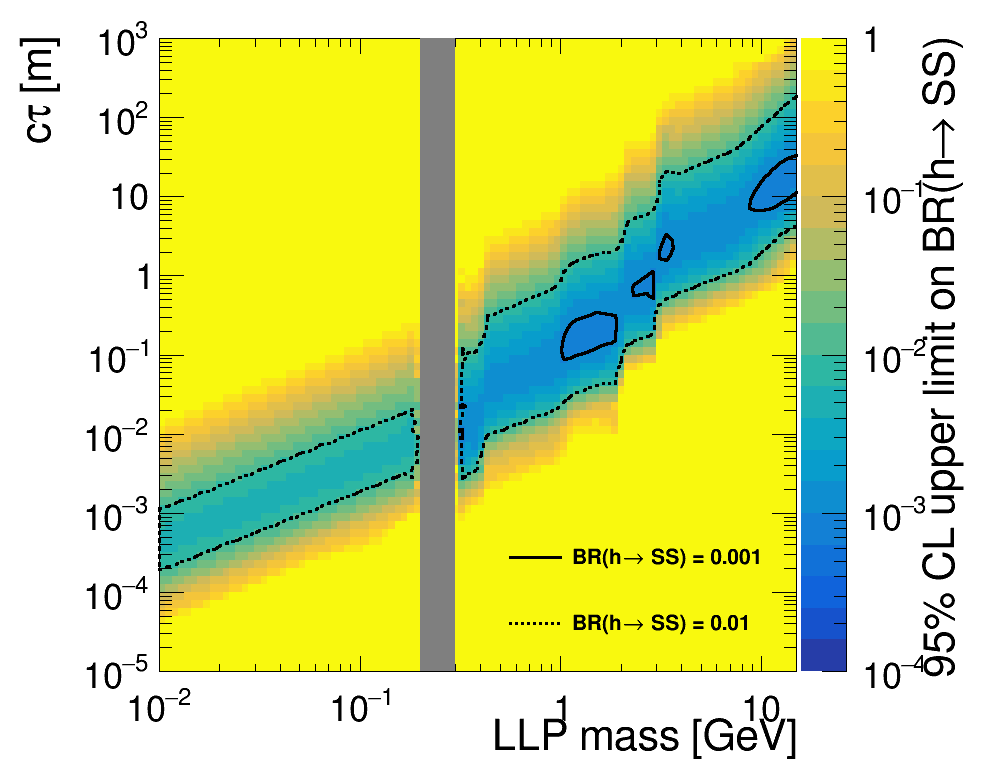

In [31]:



leg = rt.TLegend(0.5,0.15,0.8,0.32)

leg.SetFillStyle(0)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
rt.gStyle.SetLegendFillColor(1)
leg.SetEntrySeparation(0.01)
        
        
for i in range(len(cont_gr)):
    leg.AddEntry(cont_gr[i],'BR(h#rightarrow SS) = '+str(contours[i]), 'L')

b.SetFillColor(14)
# b.SetFillColorAlpha(15,1)
b.Draw('fsame')  
leg.Draw()
c.Draw()

output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/limits/'+version+'/'+dc_version+'/'+unblind+'/'
if not os.path.isdir(output_dir):os.makedirs(output_dir)
name = output_dir+'2dlimit_mixbr'


#     print(name)
c.SaveAs(name+'_2d_expected.png')
c.SaveAs(name+'_2d_expected.C')
c.SaveAs(name+'_2d_expected.pdf')
